In [2]:
import numpy as np

In [2]:
from ase import Atoms
from ase.calculators.emt import EMT

atom = Atoms('N')
atom.calc = EMT()
e_atom = atom.get_potential_energy()

d = 1.1
molecule = Atoms('2N', [(0., 0., 0.), (0., 0., d)])
molecule.calc = EMT()
e_molecule = molecule.get_potential_energy()

e_atomization = e_molecule - 2 * e_atom

print('Nitrogen atom energy: %5.2f eV' % e_atom)
print('Nitrogen molecule energy: %5.2f eV' % e_molecule)
print('Atomization energy: %5.2f eV' % -e_atomization)


Nitrogen atom energy:  5.10 eV
Nitrogen molecule energy:  0.44 eV
Atomization energy:  9.76 eV


In [6]:
import ase
import nequip
from nequip.ase import NequIPCalculator
from ase import Atoms,  units
from ase.io import read,write
from ase.visualize import view
from ase.io.trajectory import Trajectory
import numpy as np
from ase.geometry import get_layers
from ase.build import surface, bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.nvtberendsen import NVTBerendsen
from ase.cluster.cubic import FaceCenteredCubic
import numpy as np
import torch
from ase.io import read, write
from ase.md import VelocityVerlet, Langevin
from ase import units
import random

substrate_to_use="rutile"
nanoparticlesize="small"
temp = 300 #424
oxy=5

#set calculator
calculator = NequIPCalculator.from_deployed_model(
    model_path="8potbestnn.pth",
    species_to_type_name = {
        "Au": "Au",
        "Ti": "Ti",
        "O": "O"
    },
    # energy_units_to_eV=0.043,
    device='cpu')


##struc
if substrate_to_use=="rutile":
    ######## rutile 101
    atoms = read("TiO2rutile.cif")
    s=surface(atoms,(1,0,1),3,vacuum=10)
    s.translate([0,0,-10])
    news = s.repeat((7,7,1))
    del news[(news.positions[::,2]).round(2)==min(news[news.symbols=="O"].positions[::,2]).round(2)]
    del news[(news.positions[::,2]).round(2)==min(news[news.symbols=="O"].positions[::,2]).round(2)]
    del news[(news.positions[::,2]).round(2)==min(news[news.symbols=="Ti"].positions[::,2]).round(2)]
    del news[(news.positions[::,2]).round(2)==min(news[news.symbols=="Ti"].positions[::,2]).round(2)]
    listofatoms = (news.positions[::,2]).round(2)==max(news[news.symbols=="O"].positions[::,2]).round(2)
    listofatomsb = (news.positions[::,2]).round(2)==min(news[news.symbols=="O"].positions[::,2]).round(2)
    for idx,i in enumerate(listofatoms):
        if i==True:
            listofatoms[idx]=random.choices([True, False],weights=(100-oxy,oxy))[0]

    for idx,i in enumerate(listofatomsb):
        if i==True:
            listofatomsb[idx]=random.choices([True, False],weights=(100-oxy,oxy))[0]

    del news[listofatomsb+listofatoms]

    substrate = news
    substraterutile = substrate 
    zsurface  = max(news.positions[::,2])
    zcell = substrate.cell[2,2]
    ########
    substrate =substraterutile

if substrate_to_use=="anatase":
    ##atanatase 101 surfaces
    atoms = read("TiO2_mp-390_conventional_standard.cif")
    s=surface(atoms,(1,0,1),8,vacuum=10)
    s.translate([0,0,-10])

    news = s.repeat((8,16,1))

    del news[(news.positions[::,2]).round(2)==min(news[news.symbols=="O"].positions[::,2]).round(2)]
    del news[(news.positions[::,2]).round(2)==min(news[news.symbols=="O"].positions[::,2]).round(2)]
    del news[(news.positions[::,2]).round(2)==min(news[news.symbols=="Ti"].positions[::,2]).round(2)]
    del news[(news.positions[::,2]).round(2)==min(news[news.symbols=="Ti"].positions[::,2]).round(2)]

    listofatoms = (news.positions[::,2]).round(2)==max(news[news.symbols=="O"].positions[::,2]).round(2)
    listofatomsb = (news.positions[::,2]).round(2)==min(news[news.symbols=="O"].positions[::,2]).round(2)

    for idx,i in enumerate(listofatoms):
        if i==True:
            listofatoms[idx]=random.choices([True, False],weights=(100-oxy,oxy))[0]

    for idx,i in enumerate(listofatomsb):
        if i==True:
            listofatomsb[idx]=random.choices([True, False],weights=(100-oxy,oxy))[0]

    del news[listofatomsb+listofatoms]

    substrate = news
    substrateanatase = substrate 
    zsurface  = max(news.positions[::,2])
    zcell = substrate.cell[2,2]
    ##########################################################

    substrate=substrateanatase
    

#nanoparticle

surfaces = [(1, 1, 1),(-1,-1,-1),(1,0,0)] # These are the surfaces I will include
if nanoparticlesize=="small":
    layers=[4,2,5]
if nanoparticlesize=="medium":
    layers=[5,3,6]
if nanoparticlesize=="big":
    layers=[6,5,7]
if nanoparticlesize=="superbig":
    layers=[7,4,8]
    
    
np = FaceCenteredCubic('Au', surfaces, layers)
np.rotate((1,1,1),(0,0,1))
np.cell = substrate.cell
np.center()
np.translate([0,0,1])
np.rotate(v=(0,0,1),a=75,center='COU')


znp  = min(np.positions[::,2])
zsize = max(np.positions[::,2])-min(np.positions[::,2])
np.translate([0,0,-znp+zsurface+2.0])
znp  = min(np.positions[::,2])
np.translate([0,0,-znp+zsurface+2.1])
# np.rotate(v=(0,0,1),a=30,center='COU')

atoms = substrate + np
atoms.center(vacuum=5,axis=2)


t1 = Trajectory('atoms_to_run.traj', 'a')
t1.write(atoms)
atoms = read("atoms_to_run.traj")

atoms.calc=calculator
# del np 
# import numpy as np
# temp = np.zeros((len(atoms),3))
# for i in atoms:
#     index=i.index
#     if i.symbol=="Au":
#         temp[index]=[600,600,600]
#     else: temp[index]=[300,300,300]




# atoms.calc = calculator
# atoms.pbc = [True,True,False]

# trajectory = Trajectory("substrate{}_nanoparticle{}oxygen{}.traj".format(substrate_to_use,nanoparticlesize,oxy), "w", atoms)

# #MaxwellBoltzmannDistribution(atoms, temperature_K=1*temp) #give momenta to atoms according to 300K
# #MaxwellBoltzmannDistribution(atoms, temperature_K=0.5*300) #give momenta to atoms according to 300K
# dyn = Langevin(atoms, timestep=1*units.fs, temperature=temp*units.kB,friction=0.005)
# dyn.attach(trajectory, interval=50)
# dyn.run(1550)
# del atoms[(atoms.positions[::,2]-atoms.cell[2,2]/2)**2>(atoms.cell[2,2]/2)**2]
# del np
# import numpy as np
# temp = np.zeros((len(atoms),3))
# for i in atoms:
#     index=i.index
#     if i.symbol=="Au":
#         temp[index]=[600,600,600]
#     else: temp[index]=[300,300,300]

        
# for i in range(30):
#     dyn = Langevin(atoms, timestep=1*units.fs, temperature=temp*units.kB,friction=0.005)
#     dyn.attach(trajectory, interval=100)
#     dyn.run(500)
#     del atoms[(atoms.positions[::,2]-atoms.cell[2,2]/2)**2>(atoms.cell[2,2]/2)**2]
#     del np
#     import numpy as np
#     temp = np.zeros((len(atoms),3))
#     for i in atoms:
#         index=i.index
#         if i.symbol=="Au":
#             temp[index]=[600,600,600]
#         else: temp[index]=[300,300,300]
    
# for i in range(300):
#     dyn = VelocityVerlet(atoms, 2*units.fs)
#     dyn.attach(trajectory, interval=50) 
#     dyn.run(500)
#     del atoms[(atoms.positions[::,2]-atoms.cell[2,2]/2)**2>(atoms.cell[2,2]/2)**2]

C:\ProgramData\Miniconda3\lib\site-packages\nequip\utils\_global_options.py:59: UserWarning: Setting the GLOBAL value for jit fusion strategy to `[('DYNAMIC', 3)]` which is different than the previous value of `[('STATIC', 2), ('DYNAMIC', 10)]`
  f"Setting the GLOBAL value for jit fusion strategy to `{new_strat}` which is different than the previous value of `{old_strat}`"


In [14]:
view(atoms)

In [15]:
print(atoms.get_forces())

[[ 0.8696178  -1.7590066   1.7088649 ]
 [-1.4395887  -0.79026914  1.732662  ]
 [ 0.17353123  0.3963975  -0.0403138 ]
 ...
 [ 0.01232634 -0.21453097 -0.27160248]
 [-0.04746277 -0.08220717  0.6208082 ]
 [-0.00774002  0.01339289  0.02173525]]


In [12]:
view(atoms)

In [66]:
import torch.nn as nn
import torch.optim as optim
import random
from ase import Atoms
import numpy as np
import torch

# Function to build the graph
def build_graph(atoms, cutoff=5.0):
    # Compute distances between atoms
    distances = atoms.get_all_distances()
    
    # Get atomic numbers and reshape for concatenation
    atomic_numbers = atoms.get_atomic_numbers().reshape(-1, 1).astype(float)
    
    # Concatenate atomic numbers and distances as features
    features = np.hstack([atomic_numbers, distances])
    
    # Create adjacency matrix: 1 if distance is below cutoff, 0 otherwise (and set diagonal to 0)
    adjacency_matrix = (distances < cutoff).astype(float)
    np.fill_diagonal(adjacency_matrix, 0)
    
    return torch.tensor(features, dtype=torch.float32), torch.tensor(adjacency_matrix, dtype=torch.float32)

# Define the flexible Graph Neural Network (GNN) class
class FlexibleGNN(nn.Module):
    def __init__(self, input_dim, layers):
        super(FlexibleGNN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Add linear layers with ReLU activation functions
        last_dim = input_dim
        for layer_dim in layers:
            self.layers.append(nn.Linear(last_dim, layer_dim))
            last_dim = layer_dim
        
        # Output layer: predicting energy (single scalar)
        self.out_layer = nn.Linear(last_dim, 1)

    # Forward pass through the network
    def forward(self, x, adj_matrix):
        for layer in self.layers:
            x = torch.matmul(adj_matrix, x)
            x = nn.ReLU()(layer(x))  # Apply ReLU activation function
        # Output layer
        x = self.out_layer(x)
        return x

# Function to compute energies
def compute_energy(atoms, cutoff=5.0):
    # Compute distances between atoms
    distances = atoms.get_all_distances()
    
    # Get atomic numbers
    atomic_numbers = atoms.get_atomic_numbers()
    Z1 = atomic_numbers.reshape(-1, 1)
    Z2 = atomic_numbers.reshape(1, -1)
    
    # Compute interaction values
    interaction_values = Z1 * Z2 * np.sin(distances) / distances
    np.fill_diagonal(interaction_values, 0)
    
    # Compute energies
    energies = np.sum(np.where(distances < cutoff, interaction_values, 0), axis=1)
    
    return energies

# Test the function
positions = [
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0]
]
atoms = Atoms('H2O2', positions=positions)
energies = compute_energy(atoms, cutoff=5.0)
print(energies)

# Construct dataset
from ase import Atoms
import numpy as np

# Function to shake atom positions
def shake_positions(positions, scale=0.1):
    return positions + np.random.normal(scale=scale, size=positions.shape)

# Initial positions for H2O
initial_positions = [
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0]
]

# Number of atoms to add in each step
num_atoms_per_step = 2

# Number of steps to generate 30 atoms
num_steps = 15

# Create an empty list to store the trajectory
trajectory = []

# Add the initial configuration
atoms = Atoms('H2O2', positions=initial_positions)
trajectory.append(atoms)

# Generate additional configurations
for _ in range(num_steps):
    # Copy the previous configuration and shake the positions of the H2O atoms
    new_positions = shake_positions(trajectory[-1].positions[0:4], scale=0.1)
    
    # Create new atoms object with the shaken positions
    new_atoms = Atoms('H2O2', positions=np.vstack([trajectory[-1].positions[4:], new_positions]))
    
    # Append to the trajectory
    trajectory.append(new_atoms)

# Check the total number of atoms in the trajectory
total_atoms = sum(len(atoms) for atoms in trajectory)
print("Total number of atoms in the trajectory:", total_atoms)

#

      
data_list = []
for atoms in trajectory:
    node_features, adj_matrix = build_graph(atoms, cutoff=5.0)
    energies = compute_energy(atoms, cutoff=5.0)
    data_list.append((node_features, adj_matrix, torch.tensor(energies, dtype=torch.float32)))


# Define loss function
criterion = torch.nn.MSELoss()
# Define and instantiate the FlexibleGNN model
num_atoms = len(atoms)
input_dim = num_atoms + 1  # +1 for the atomic number
layers = [32,64,32]
gnn = FlexibleGNN(input_dim=input_dim, layers=layers)
print("this is the gnn",gnn)
# Set the learning rate and define the optimizer
learning_rate = 0.01
optimizer = optim.Adam(gnn.parameters(), lr=learning_rate)


# Define the scheduler
# This will multiply the learning rate by 0.1 every 100 epochs
scheduler = StepLR(optimizer, step_size=115, gamma=0.4)
# Training loop
num_epochs = 1100
for epoch in range(num_epochs):
    total_loss = 0.0
    
    # Iterate over the dataset
    for node_features, adj_matrix, target_energies in data_list:
        # Forward pass
        outputs = gnn(node_features, adj_matrix)
        loss = criterion(outputs, target_energies.unsqueeze(-1))  # make target_energies two-dimensional
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Step the scheduler
    scheduler.step()
    
    # Print the averaged loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_list)}, Learning rate: {scheduler.get_last_lr()[0]}")


C:\Users\cuau_\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


[14.30500674 12.01676696 57.02059978 57.02059978]
Total number of atoms in the trajectory: 64
this is the gnn FlexibleGNN(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (out_layer): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 1/1100, Loss: 837.2981719970703, Learning rate: 0.01
Epoch 2/1100, Loss: 824.7055568695068, Learning rate: 0.01
Epoch 3/1100, Loss: 913.5705585479736, Learning rate: 0.01
Epoch 4/1100, Loss: 769.2488136291504, Learning rate: 0.01
Epoch 5/1100, Loss: 720.9996528625488, Learning rate: 0.01
Epoch 6/1100, Loss: 731.9228954315186, Learning rate: 0.01
Epoch 7/1100, Loss: 743.6644172668457, Learning rate: 0.01
Epoch 8/1100, Loss: 742.5925064086914, Learning rate: 0.01
Epoch 9/1100, Loss: 736.6702709197998, Learning rate: 0.01
Epoch 10/1100, Loss: 730.6513366699219, Learning rate: 0.01
Epoch 11/110

Epoch 131/1100, Loss: 537.1973094940186, Learning rate: 0.004
Epoch 132/1100, Loss: 536.6755790710449, Learning rate: 0.004
Epoch 133/1100, Loss: 533.9571132659912, Learning rate: 0.004
Epoch 134/1100, Loss: 533.3078155517578, Learning rate: 0.004
Epoch 135/1100, Loss: 530.2440853118896, Learning rate: 0.004
Epoch 136/1100, Loss: 528.1656513214111, Learning rate: 0.004
Epoch 137/1100, Loss: 525.6216983795166, Learning rate: 0.004
Epoch 138/1100, Loss: 524.0273303985596, Learning rate: 0.004
Epoch 139/1100, Loss: 520.7013931274414, Learning rate: 0.004
Epoch 140/1100, Loss: 519.3116397857666, Learning rate: 0.004
Epoch 141/1100, Loss: 515.4420280456543, Learning rate: 0.004
Epoch 142/1100, Loss: 515.3932666778564, Learning rate: 0.004
Epoch 143/1100, Loss: 510.051794052124, Learning rate: 0.004
Epoch 144/1100, Loss: 508.68957138061523, Learning rate: 0.004
Epoch 145/1100, Loss: 502.02830696105957, Learning rate: 0.004
Epoch 146/1100, Loss: 502.1048698425293, Learning rate: 0.004
Epoch 1

Epoch 265/1100, Loss: 34.54797399044037, Learning rate: 0.0016
Epoch 266/1100, Loss: 31.943633675575256, Learning rate: 0.0016
Epoch 267/1100, Loss: 35.616115272045135, Learning rate: 0.0016
Epoch 268/1100, Loss: 37.77658358216286, Learning rate: 0.0016
Epoch 269/1100, Loss: 30.26192796230316, Learning rate: 0.0016
Epoch 270/1100, Loss: 30.55789178609848, Learning rate: 0.0016
Epoch 271/1100, Loss: 37.326028764247894, Learning rate: 0.0016
Epoch 272/1100, Loss: 42.16181343793869, Learning rate: 0.0016
Epoch 273/1100, Loss: 32.31054323911667, Learning rate: 0.0016
Epoch 274/1100, Loss: 28.976816326379776, Learning rate: 0.0016
Epoch 275/1100, Loss: 35.301265984773636, Learning rate: 0.0016
Epoch 276/1100, Loss: 36.37650844454765, Learning rate: 0.0016
Epoch 277/1100, Loss: 26.732350289821625, Learning rate: 0.0016
Epoch 278/1100, Loss: 29.06078776717186, Learning rate: 0.0016
Epoch 279/1100, Loss: 38.46218687295914, Learning rate: 0.0016
Epoch 280/1100, Loss: 31.22746181488037, Learning

Epoch 395/1100, Loss: 9.409606482833624, Learning rate: 0.00064
Epoch 396/1100, Loss: 9.546683389693499, Learning rate: 0.00064
Epoch 397/1100, Loss: 9.457525808364153, Learning rate: 0.00064
Epoch 398/1100, Loss: 9.27803397551179, Learning rate: 0.00064
Epoch 399/1100, Loss: 9.449800867587328, Learning rate: 0.00064
Epoch 400/1100, Loss: 9.341386798769236, Learning rate: 0.00064
Epoch 401/1100, Loss: 9.169853214174509, Learning rate: 0.00064
Epoch 402/1100, Loss: 9.325959974899888, Learning rate: 0.00064
Epoch 403/1100, Loss: 9.21273497492075, Learning rate: 0.00064
Epoch 404/1100, Loss: 9.18013720586896, Learning rate: 0.00064
Epoch 405/1100, Loss: 9.149011880159378, Learning rate: 0.00064
Epoch 406/1100, Loss: 9.067510087043047, Learning rate: 0.00064
Epoch 407/1100, Loss: 9.052808947861195, Learning rate: 0.00064
Epoch 408/1100, Loss: 9.083195999264717, Learning rate: 0.00064
Epoch 409/1100, Loss: 9.073563637211919, Learning rate: 0.00064
Epoch 410/1100, Loss: 8.855469889938831, Le

Epoch 515/1100, Loss: 6.277864160016179, Learning rate: 0.00025600000000000004
Epoch 516/1100, Loss: 6.111568436026573, Learning rate: 0.00025600000000000004
Epoch 517/1100, Loss: 6.153274845331907, Learning rate: 0.00025600000000000004
Epoch 518/1100, Loss: 6.329136189073324, Learning rate: 0.00025600000000000004
Epoch 519/1100, Loss: 6.051200956106186, Learning rate: 0.00025600000000000004
Epoch 520/1100, Loss: 6.225703718140721, Learning rate: 0.00025600000000000004
Epoch 521/1100, Loss: 6.103267252445221, Learning rate: 0.00025600000000000004
Epoch 522/1100, Loss: 6.2313648872077465, Learning rate: 0.00025600000000000004
Epoch 523/1100, Loss: 6.048612266778946, Learning rate: 0.00025600000000000004
Epoch 524/1100, Loss: 6.209988716989756, Learning rate: 0.00025600000000000004
Epoch 525/1100, Loss: 6.0403742007911205, Learning rate: 0.00025600000000000004
Epoch 526/1100, Loss: 6.122510526329279, Learning rate: 0.00025600000000000004
Epoch 527/1100, Loss: 6.184899611398578, Learning 

Epoch 621/1100, Loss: 5.293504603207111, Learning rate: 0.00010240000000000002
Epoch 622/1100, Loss: 5.241427607834339, Learning rate: 0.00010240000000000002
Epoch 623/1100, Loss: 5.252404663711786, Learning rate: 0.00010240000000000002
Epoch 624/1100, Loss: 5.246334798634052, Learning rate: 0.00010240000000000002
Epoch 625/1100, Loss: 5.212492575868964, Learning rate: 0.00010240000000000002
Epoch 626/1100, Loss: 5.219064956530929, Learning rate: 0.00010240000000000002
Epoch 627/1100, Loss: 5.2216117437928915, Learning rate: 0.00010240000000000002
Epoch 628/1100, Loss: 5.212666191160679, Learning rate: 0.00010240000000000002
Epoch 629/1100, Loss: 5.2091250363737345, Learning rate: 0.00010240000000000002
Epoch 630/1100, Loss: 5.207488624379039, Learning rate: 0.00010240000000000002
Epoch 631/1100, Loss: 5.2688173577189445, Learning rate: 0.00010240000000000002
Epoch 632/1100, Loss: 5.214907320216298, Learning rate: 0.00010240000000000002
Epoch 633/1100, Loss: 5.219300566241145, Learning

Epoch 728/1100, Loss: 4.868560388684273, Learning rate: 4.0960000000000014e-05
Epoch 729/1100, Loss: 4.8668566737324, Learning rate: 4.0960000000000014e-05
Epoch 730/1100, Loss: 4.86826977878809, Learning rate: 4.0960000000000014e-05
Epoch 731/1100, Loss: 4.864958023652434, Learning rate: 4.0960000000000014e-05
Epoch 732/1100, Loss: 4.866473019123077, Learning rate: 4.0960000000000014e-05
Epoch 733/1100, Loss: 4.864749401807785, Learning rate: 4.0960000000000014e-05
Epoch 734/1100, Loss: 4.865449342876673, Learning rate: 4.0960000000000014e-05
Epoch 735/1100, Loss: 4.881811054423451, Learning rate: 4.0960000000000014e-05
Epoch 736/1100, Loss: 4.857517706230283, Learning rate: 4.0960000000000014e-05
Epoch 737/1100, Loss: 4.871251756325364, Learning rate: 4.0960000000000014e-05
Epoch 738/1100, Loss: 4.860784819349647, Learning rate: 4.0960000000000014e-05
Epoch 739/1100, Loss: 4.852283578366041, Learning rate: 4.0960000000000014e-05
Epoch 740/1100, Loss: 4.852904435247183, Learning rate:

Epoch 835/1100, Loss: 4.722715796902776, Learning rate: 1.6384000000000008e-05
Epoch 836/1100, Loss: 4.719285499304533, Learning rate: 1.6384000000000008e-05
Epoch 837/1100, Loss: 4.727842688560486, Learning rate: 1.6384000000000008e-05
Epoch 838/1100, Loss: 4.715662036091089, Learning rate: 1.6384000000000008e-05
Epoch 839/1100, Loss: 4.72061488032341, Learning rate: 1.6384000000000008e-05
Epoch 840/1100, Loss: 4.719684787094593, Learning rate: 1.6384000000000008e-05
Epoch 841/1100, Loss: 4.716357201337814, Learning rate: 1.6384000000000008e-05
Epoch 842/1100, Loss: 4.7158940769732, Learning rate: 1.6384000000000008e-05
Epoch 843/1100, Loss: 4.715787762776017, Learning rate: 1.6384000000000008e-05
Epoch 844/1100, Loss: 4.716280810534954, Learning rate: 1.6384000000000008e-05
Epoch 845/1100, Loss: 4.717180186882615, Learning rate: 1.6384000000000008e-05
Epoch 846/1100, Loss: 4.71727592498064, Learning rate: 1.6384000000000008e-05
Epoch 847/1100, Loss: 4.714650202542543, Learning rate: 

Epoch 942/1100, Loss: 4.660713808611035, Learning rate: 6.553600000000004e-06
Epoch 943/1100, Loss: 4.658739050850272, Learning rate: 6.553600000000004e-06
Epoch 944/1100, Loss: 4.662000665441155, Learning rate: 6.553600000000004e-06
Epoch 945/1100, Loss: 4.658271254971623, Learning rate: 6.553600000000004e-06
Epoch 946/1100, Loss: 4.65961697883904, Learning rate: 6.553600000000004e-06
Epoch 947/1100, Loss: 4.65872055478394, Learning rate: 6.553600000000004e-06
Epoch 948/1100, Loss: 4.658073319122195, Learning rate: 6.553600000000004e-06
Epoch 949/1100, Loss: 4.658656815066934, Learning rate: 6.553600000000004e-06
Epoch 950/1100, Loss: 4.658358819782734, Learning rate: 6.553600000000004e-06
Epoch 951/1100, Loss: 4.657384280115366, Learning rate: 6.553600000000004e-06
Epoch 952/1100, Loss: 4.657511321827769, Learning rate: 6.553600000000004e-06
Epoch 953/1100, Loss: 4.657438246533275, Learning rate: 6.553600000000004e-06
Epoch 954/1100, Loss: 4.656870720908046, Learning rate: 6.55360000

Epoch 1048/1100, Loss: 4.634504439309239, Learning rate: 2.6214400000000015e-06
Epoch 1049/1100, Loss: 4.634416464716196, Learning rate: 2.6214400000000015e-06
Epoch 1050/1100, Loss: 4.634414141997695, Learning rate: 2.6214400000000015e-06
Epoch 1051/1100, Loss: 4.634315814822912, Learning rate: 2.6214400000000015e-06
Epoch 1052/1100, Loss: 4.634254455566406, Learning rate: 2.6214400000000015e-06
Epoch 1053/1100, Loss: 4.634232206270099, Learning rate: 2.6214400000000015e-06
Epoch 1054/1100, Loss: 4.633985817432404, Learning rate: 2.6214400000000015e-06
Epoch 1055/1100, Loss: 4.634037617594004, Learning rate: 2.6214400000000015e-06
Epoch 1056/1100, Loss: 4.633866725489497, Learning rate: 2.6214400000000015e-06
Epoch 1057/1100, Loss: 4.634147219359875, Learning rate: 2.6214400000000015e-06
Epoch 1058/1100, Loss: 4.634324133396149, Learning rate: 2.6214400000000015e-06
Epoch 1059/1100, Loss: 4.6335359942168, Learning rate: 2.6214400000000015e-06
Epoch 1060/1100, Loss: 4.633977131918073, 

In [67]:
# Assuming you have a trained GNN model named 'gnn', and test trajectory files named 'test_trajectory_files'
# Create an empty list to store the trajectory
test_trajectory_files = []

# Add the initial configuration
atoms = Atoms('H2O2', positions=initial_positions)
test_trajectory_files.append(atoms)

# Generate additional configurations
for _ in range(num_steps):
    # Copy the previous configuration and shake the positions of the H2O atoms
    new_positions = shake_positions(trajectory[-1].positions[0:4], scale=0.1)
    
    # Create new atoms object with the shaken positions
    new_atoms = Atoms('H2O2', positions=np.vstack([trajectory[-1].positions[4:], new_positions]))
    
    # Append to the trajectory
    test_trajectory_files.append(new_atoms)

# 1. Load your test trajectory files and generate test data
test_data_list = []
for test_traj_file in test_trajectory_files:
    test_atoms = test_traj_file
    test_node_features, test_adj_matrix = build_graph(test_atoms, cutoff=5.0)
    test_energies = compute_energy(test_atoms, cutoff=5.0)
    test_data_list.append((test_node_features, test_adj_matrix, torch.tensor(test_energies, dtype=torch.float32)))

# 2. Evaluate the model on the test data
test_losses = []
for node_features, adj_matrix, target_energies in test_data_list:
    test_outputs = gnn(node_features, adj_matrix)
    test_loss = criterion(test_outputs, target_energies.unsqueeze(-1))
    test_losses.append(test_loss.item())

# 3. Print the average test loss
avg_test_loss = sum(test_losses) / len(test_losses)
print("Average test loss:", avg_test_loss)


Average test loss: 51.99882510304451


C:\Users\cuau_\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


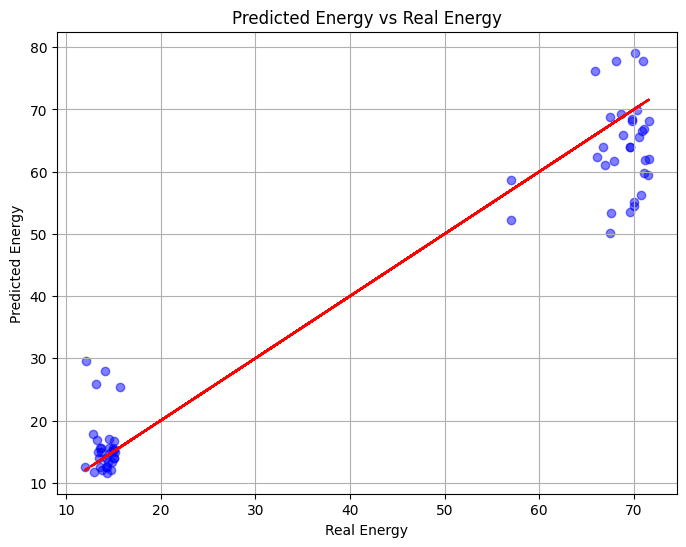

In [68]:
import matplotlib.pyplot as plt

# Prepare lists to store predicted and real energy values
predicted_energies = []
real_energies = []

# Pass the test data through the trained GNN model to obtain predictions
for node_features, adj_matrix, target_energies in test_data_list:
    test_outputs = gnn(node_features, adj_matrix)
    predicted_energies.extend(test_outputs.detach().numpy().flatten())  # Convert torch tensor to numpy array
    real_energies.extend(target_energies.numpy())

# Plot predicted energy vs real energy
plt.figure(figsize=(8, 6))
plt.scatter(real_energies, predicted_energies, color='blue', alpha=0.5)
plt.plot(real_energies, real_energies, color='red', linestyle='--')  # Plot y = x line for reference
plt.xlabel('Real Energy')
plt.ylabel('Predicted Energy')
plt.title('Predicted Energy vs Real Energy')
plt.grid(True)
plt.show()


In [3]:
from ase.collections import g2


In [4]:
print(g2.names)  
"C6 H15 N2 O2" 

['PH3', 'P2', 'CH3CHO', 'H2COH', 'CS', 'OCHCHO', 'C3H9C', 'CH3COF', 'CH3CH2OCH3', 'HCOOH', 'HCCl3', 'HOCl', 'H2', 'SH2', 'C2H2', 'C4H4NH', 'CH3SCH3', 'SiH2_s3B1d', 'CH3SH', 'CH3CO', 'CO', 'ClF3', 'SiH4', 'C2H6CHOH', 'CH2NHCH2', 'isobutene', 'HCO', 'bicyclobutane', 'LiF', 'Si', 'C2H6', 'CN', 'ClNO', 'S', 'SiF4', 'H3CNH2', 'methylenecyclopropane', 'CH3CH2OH', 'F', 'NaCl', 'CH3Cl', 'CH3SiH3', 'AlF3', 'C2H3', 'ClF', 'PF3', 'PH2', 'CH3CN', 'cyclobutene', 'CH3ONO', 'SiH3', 'C3H6_D3h', 'CO2', 'NO', 'trans-butane', 'H2CCHCl', 'LiH', 'NH2', 'CH', 'CH2OCH2', 'C6H6', 'CH3CONH2', 'cyclobutane', 'H2CCHCN', 'butadiene', 'C', 'H2CO', 'CH3COOH', 'HCF3', 'CH3S', 'CS2', 'SiH2_s1A1d', 'C4H4S', 'N2H4', 'OH', 'CH3OCH3', 'C5H5N', 'H2O', 'HCl', 'CH2_s1A1d', 'CH3CH2SH', 'CH3NO2', 'Cl', 'Be', 'BCl3', 'C4H4O', 'Al', 'CH3O', 'CH3OH', 'C3H7Cl', 'isobutane', 'Na', 'CCl4', 'CH3CH2O', 'H2CCHF', 'C3H7', 'CH3', 'O3', 'P', 'C2H4', 'NCCN', 'S2', 'AlCl3', 'SiCl4', 'SiO', 'C3H4_D2d', 'H', 'COF2', '2-butyne', 'C2H5', 'BF3'

In [70]:
from ase.build import molecule
atoms = read('C:/Users/cuau_/Downloads/protein.xyz')
view(atoms)

In [48]:
atoms

Atoms(symbols='O2N2C6H14', pbc=False)

In [69]:
import torch

def calculate_total_energy(atoms, gnn_model, cutoff=5.0):
    # Step 1: Convert Atoms object into node features and adjacency matrix
    node_features, adj_matrix = build_graph(atoms, cutoff=cutoff)
    
    # Step 2: Pass node features and adjacency matrix through the GNN model
    predicted_energies = gnn_model(node_features, adj_matrix)
    
    # Step 3: Sum up the predicted energies to get the total energy
    total_energy = torch.sum(predicted_energies).item()
    
    return total_energy

# Example usage:
gnn_model = gnn
total_energy = calculate_total_energy(atoms, gnn)
print("Total energy:", total_energy)


Total energy: 136.04171752929688
